Displaying Integrated Gradients for conv2d_2


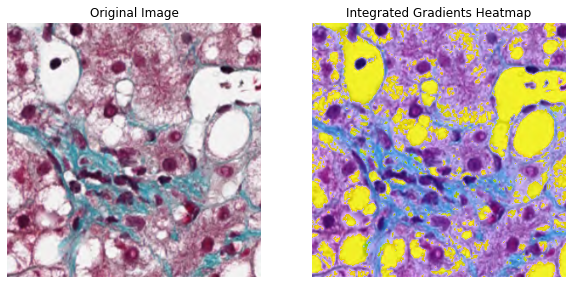

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

# Load models
resnet50_model = load_model('D:/PATENT/Model_testing/inflam_modified25.h5')

# Load training history
with open('D:/PATENT/Model_testing/inflam_modified_history25.json', 'r') as f:
    resnet50_history = json.load(f)

# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)  # Load and resize the image
    x = img_to_array(img)  # Convert to array
    x = np.expand_dims(x, axis=0)  # Add batch dimension
    x = tf.keras.applications.resnet50.preprocess_input(x)  # Preprocess for ResNet50
    return tf.convert_to_tensor(x)

# Integrated Gradients Function
def compute_integrated_gradients(model, img, baseline, layer_name, steps=50):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])

    # Generate alphas and interpolated images
    alphas = np.linspace(0, 1, steps)
    interpolated_images = [(baseline + alpha * (img - baseline)) for alpha in alphas]
    interpolated_images = tf.concat(interpolated_images, axis=0)  # Correct stacking to get shape (steps, 299, 299, 3)

    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        conv_outputs, predictions = grad_model(interpolated_images)
        loss = tf.reduce_mean(predictions[:, tf.argmax(predictions[0])])

    grads = tape.gradient(loss, interpolated_images)
    avg_grads = tf.reduce_mean(grads, axis=0).numpy()

    # Compute the integrated gradients
    integrated_gradients = (img - baseline).numpy() * avg_grads
    return np.mean(integrated_gradients, axis=-1)

# Visualization function with corrections for the heatmap format
def display_integrated_gradients(image_path, heatmap, colormap=cv2.COLORMAP_JET):
    img = load_img(image_path)
    img = np.array(img)
    
    # Normalize heatmap to range [0, 255] and ensure it's a 2D grayscale image
    heatmap = np.maximum(heatmap, 0)  # Ensure all values are non-negative
    heatmap = np.uint8(255 * heatmap / np.max(heatmap)) if np.max(heatmap) != 0 else np.zeros_like(heatmap, dtype=np.uint8)

    # Ensure the heatmap is 2D and single channel
    if heatmap.ndim != 2:
        heatmap = np.mean(heatmap, axis=-1).astype(np.uint8)  # Convert to single-channel if it has more dimensions

    # Apply color map on heatmap (ensure heatmap is 2D)
    heatmap = cv2.applyColorMap(heatmap, colormap)  # Apply the colormap
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for proper display
    
    # Overlay the heatmap on the original image
    superimposed_img = heatmap * 0.4 + img
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img.astype('uint8'))
    plt.title('Integrated Gradients Heatmap')
    plt.axis('off')
    plt.show()


# Example Usage
img_path = "D:/DATASET/CNN/inflammation/train/1/14_160_86.png"
baseline = tf.zeros((1, 299, 299, 3))  # Baseline (e.g., all zeros)
preprocessed_img = preprocess_image(img_path, target_size=(299, 299))

layer_name = 'conv2d_2'  # Adjust as needed
integrated_heatmap = compute_integrated_gradients(resnet50_model, preprocessed_img, baseline, layer_name)

print(f"Displaying Integrated Gradients for {layer_name}")
display_integrated_gradients(img_path, integrated_heatmap)

